In [6]:
import pandas as pd
df = pd.read_csv('sales_overtime.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939 entries, 0 to 2938
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_mvt        2939 non-null   object 
 1   nb_sales        2939 non-null   int64  
 2   total_revenues  2939 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 69.0+ KB


In [8]:
df['date_mvt'] = pd.to_datetime(df['date_mvt'],format='%Y-%m-%d %H:%M:%S.%f UTC')

In [29]:
df2 = df.groupby(pd.Grouper(key='date_mvt', axis=0,  freq='M')).sum()

In [30]:
df2.reset_index(inplace=True)
df2.head()

,date_mvt,nb_sales,total_revenues
0,2014-09-30,12,259.010000
1,2014-10-31,13501,270723.840000
2,2014-11-30,4287,146798.120000
3,2014-12-31,4549,146595.658571
4,2015-01-31,4434,129396.430000


In [31]:
import plotly.express as px
fig = px.line(df2,x='date_mvt',y='total_revenues')
fig


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [2]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 46.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.3 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
df3 = df2.drop('total_revenues',axis=1)

In [33]:
df3.columns = ['ds', 'y']

In [34]:
df3.head()

,ds,y
0,2014-09-30,12
1,2014-10-31,13501
2,2014-11-30,4287
3,2014-12-31,4549
4,2015-01-31,4434


In [36]:
df3.shape

(118, 2)

In [38]:
train = df3.iloc[:100]
test = df3.iloc[100:]

train.shape, test.shape

((100, 2), (18, 2))

In [ ]:
# set the index for the function seasonal_decompose to work

df3.set_index("ds", inplace = True)

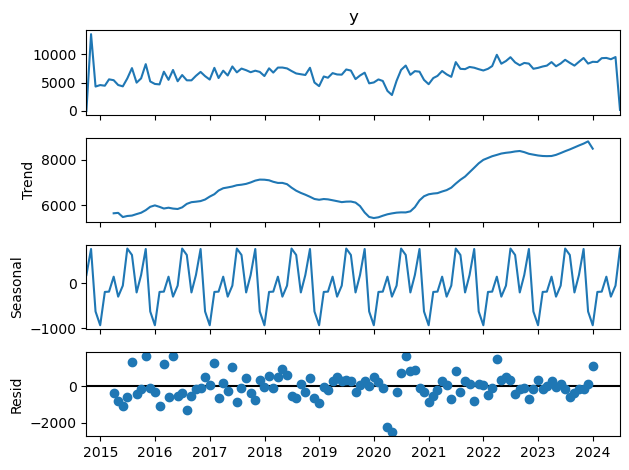

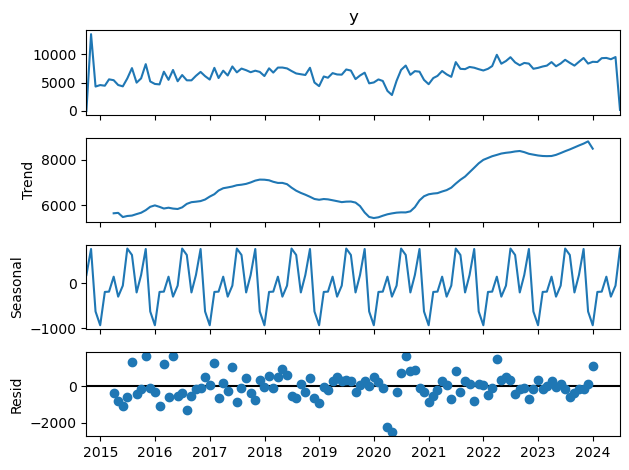

In [41]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df3['y'], model='additive')
result_add.plot()

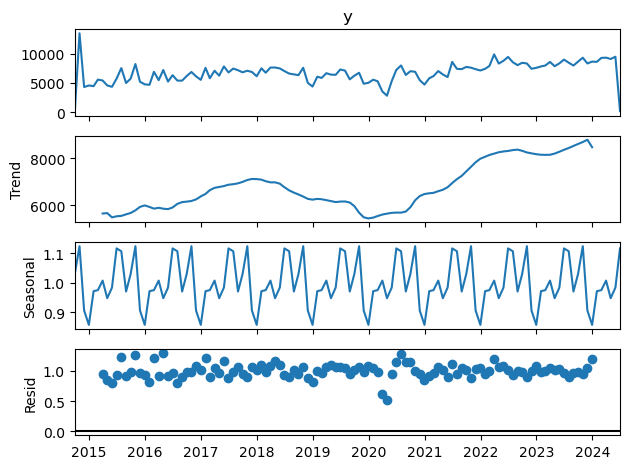

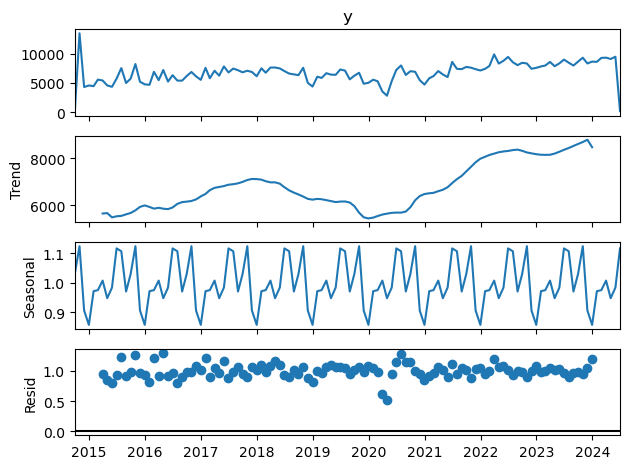

In [45]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df3['y'], model='multiplicative')
result_mul.plot()

In [46]:
# Create a multiplicative model

model = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
model.fit(train)

17:13:48 - cmdstanpy - INFO - Chain [1] start processing
17:13:48 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
horizon = 36      # is the number of data points we want to forecast in the future (starting from the end of TRAIN)

future = model.make_future_dataframe(periods=horizon, freq='M')

In [48]:
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
131,2025-08-31,8256.513541,5632.208096,10849.313615
132,2025-09-30,8004.962944,5319.982734,10629.167476
133,2025-10-31,10329.118555,7791.034701,12858.988299
134,2025-11-30,7644.339889,5167.408556,10416.072586
135,2025-12-31,7230.625137,4545.301497,9812.936035


/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



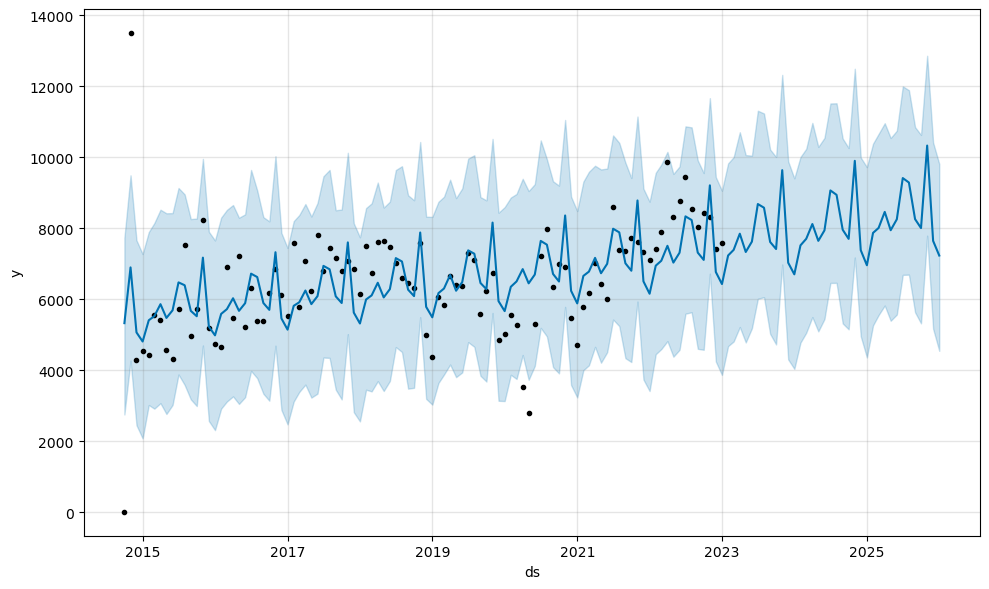

In [49]:
ax = model.plot(forecast)

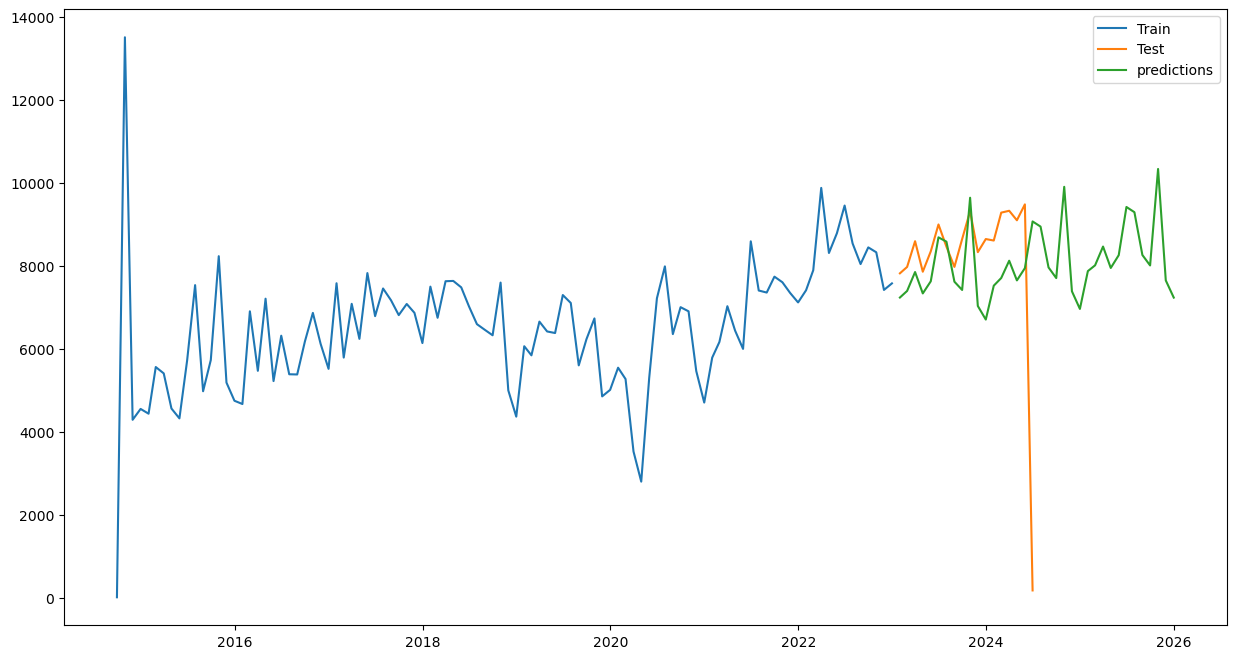

In [50]:
plt.figure(figsize=(15, 8))
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()